# Dog Breed Classification

## 1. Imports and Setup

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns

# Verify GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-12-05 21:42:44.220143: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-05 21:42:44.253330: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-05 21:42:44.976553: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Num GPUs Available:  1


## 2. Configuration

In [ ]:
# Hyperparameters and Paths
config = {
    'BATCH_SIZE': 32,
    'EPOCHS': 100,
    'LEARNING_RATE': 0.001,
    'IMAGE_SIZE': (224, 224),
    'NUM_CLASSES': 20,
    'DATA_DIR': '/Team_39/Images',
    'SEED': 42,
    'L2_REG': 1e-4
}

# Selected Dog Breeds
categories = [
    'n02088466-bloodhound',
    'n02109525-Saint_Bernard',
    'n02093647-Bedlington_terrier',
    'n02085936-Maltese_dog',
    'n02106662-German_shepherd',
    'n02106166-Border_collie',
    'n02096051-Airedale',
    'n02097298-Scotch_terrier',
    'n02091134-whippet',
    'n02091032-Italian_greyhound',
    'n02108915-French_bulldog',
    'n02108089-boxer',
    'n02091467-Norwegian_elkhound',
    'n02110063-malamute',
    'n02099712-Labrador_retriever',
    'n02099601-golden_retriever',
    'n02094433-Yorkshire_terrier',
    'n02105505-komondor',
    'n02088364-beagle',
    'n02106550-Rottweiler'
]

## 3. Data Loading and Preprocessing

In [3]:
def load_data(data_dir, categories, img_size):
    """Loads images from disk and resizes them."""
    data = []
    labels = []
    for category in categories:
        path = os.path.join(data_dir, category)
        class_num = categories.index(category)
        if not os.path.exists(path):
            continue
            
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                if img_array is not None:
                    img_array = cv2.resize(img_array, img_size)
                    data.append(img_array)
                    labels.append(class_num)
            except Exception:
                pass
    return np.array(data), np.array(labels)

print("Loading dataset...")
X, y = load_data(config['DATA_DIR'], categories, config['IMAGE_SIZE'])
print(f"Loaded {len(X)} images.")

# Split into Training and Testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=config['SEED'])

# Standardization (Zero-centering)
mean = np.mean(X_train, axis=(0, 1, 2))
std = np.std(X_train, axis=(0, 1, 2))

X_train = (X_train - mean) / (std + 1e-7)
X_test = (X_test - mean) / (std + 1e-7)

print("Data standardized.")

Loading dataset...
Loaded 3492 images.
Data standardized.


In [4]:
# Compute Class Weights to handle imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights computed.")

Class weights computed.


## 4. Data Augmentation

In [5]:
# Initialize Image Data Generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)
datagen.fit(X_train)

Sample Augmented Images:


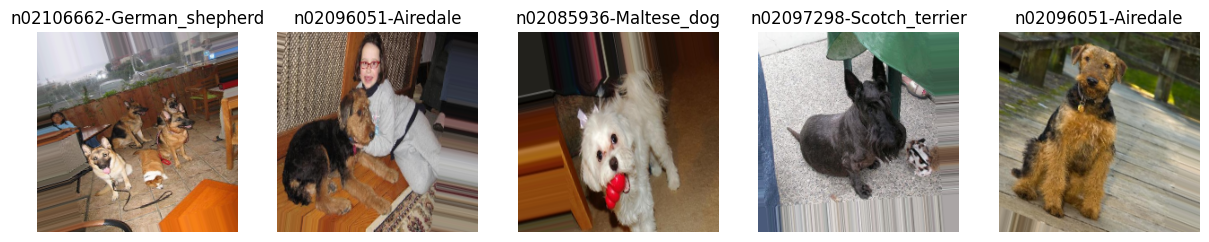

In [6]:
def visualize_augmented_samples(datagen, X, y, categories, num_samples=5):
    """Visualizes augmented samples to verify data quality."""
    plt.figure(figsize=(15, 5))
    iterator = datagen.flow(X[:num_samples], y[:num_samples], batch_size=1)
    
    for i in range(num_samples):
        batch = next(iterator)
        img = batch[0][0]
        label = batch[1][0]
        
        # Reverse standardization for display
        img_vis = (img * std) + mean
        img_vis = np.clip(img_vis, 0, 255).astype('uint8')
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
        plt.title(categories[label])
        plt.axis('off')
    plt.show()

print("Sample Augmented Images:")
visualize_augmented_samples(datagen, X_train, y_train, categories)

## 5. Model Architecture (ResNet-34)

In [7]:
def identity_block(x, filters, l2_reg=1e-4):
    """ResNet Identity Block: Keeps dimensions constant."""
    f1, f2 = filters
    shortcut = x
    
    # First Component
    x = Conv2D(f1, (3, 3), padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second Component
    x = Conv2D(f2, (3, 3), padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    
    # Add Shortcut
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

def conv_block(x, filters, s=2, l2_reg=1e-4):
    """ResNet Convolutional Block: Downsamples input."""
    f1, f2 = filters
    
    # Shortcut Path (Downsampling)
    shortcut = Conv2D(f2, (1, 1), strides=(s, s), kernel_regularizer=l2(l2_reg))(x)
    shortcut = BatchNormalization()(shortcut)
    
    # Main Path
    x = Conv2D(f1, (3, 3), strides=(s, s), padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(f2, (3, 3), padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    
    # Add Shortcut
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

def build_resnet_model(input_shape, num_classes, l2_reg=1e-4):
    """Builds the complete ResNet architecture."""
    img_input = Input(shape=input_shape)
    
    # Initial Convolution
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', kernel_regularizer=l2(l2_reg))(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # ResNet Stages
    x = conv_block(x, [64, 64], s=1, l2_reg=l2_reg)
    x = identity_block(x, [64, 64], l2_reg=l2_reg)
    x = identity_block(x, [64, 64], l2_reg=l2_reg)
    
    x = conv_block(x, [128, 128], s=2, l2_reg=l2_reg)
    x = identity_block(x, [128, 128], l2_reg=l2_reg)
    x = identity_block(x, [128, 128], l2_reg=l2_reg)
    
    x = conv_block(x, [256, 256], s=2, l2_reg=l2_reg)
    x = identity_block(x, [256, 256], l2_reg=l2_reg)
    x = identity_block(x, [256, 256], l2_reg=l2_reg)
    
    x = conv_block(x, [512, 512], s=2, l2_reg=l2_reg)
    x = identity_block(x, [512, 512], l2_reg=l2_reg)
    x = identity_block(x, [512, 512], l2_reg=l2_reg)
    
    # Classification Head
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_reg))(x)
    
    model = Model(inputs=img_input, outputs=x)
    return model

# Build and Summary
model = build_resnet_model(config['IMAGE_SIZE'] + (3,), config['NUM_CLASSES'], l2_reg=config['L2_REG'])
model.summary()

I0000 00:00:1764952978.387864   62293 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3962 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 17,482,068 (66.69 MB)

 Trainable params: 17,468,500 (66.64 MB)

 Non-trainable params: 13,568 (53.00 KB)

## 6. Training

In [8]:
# Learning Rate Schedule (Cosine Decay)
initial_learning_rate = config['LEARNING_RATE']
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate,
    decay_steps=config['EPOCHS'] * len(X_train) // config['BATCH_SIZE'],
    alpha=0.01
)

# Compile Model
model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    ModelCheckpoint('model.h5', save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
]

In [9]:
# Start Training
print("Starting training...")
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=config['BATCH_SIZE']),
    validation_data=(X_test, y_test),
    epochs=config['EPOCHS'],
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Starting training...
Epoch 1/100


2025-12-05 21:43:07.428377: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fd610014d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-05 21:43:07.428390: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-12-05 21:43:07.726949: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-05 21:43:09.037590: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-12-05 21:43:09.782007: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_t

 1/88 ━━━━━━━━━━━━━━━━━━━━ 25:29 18s/step - accuracy: 0.0938 - loss: 4.2042

I0000 00:00:1764952997.134106   62512 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


77/88 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.0780 - loss: 4.6214

2025-12-05 21:43:29.648645: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[9,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[9,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-12-05 21:43:29.765434: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[9,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[9,128,28,28]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.0789 - loss: 4.5500

2025-12-05 21:43:40.121249: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[27,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[27,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-12-05 21:43:40.322520: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[27,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[27,128,28,28]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target

88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 286ms/step - accuracy: 0.0849 - loss: 4.0356 - val_accuracy: 0.0286 - val_loss: 534.7763
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.0887 - loss: 3.7076

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - accuracy: 0.0960 - loss: 3.6612 - val_accuracy: 0.0443 - val_loss: 21.5542
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.1220 - loss: 3.4845

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - accuracy: 0.1199 - loss: 3.5052 - val_accuracy: 0.1059 - val_loss: 4.6302
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.1369 - loss: 3.4671

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.1364 - loss: 3.4448 - val_accuracy: 0.1159 - val_loss: 5.0770
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.1657 - loss: 3.2812

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - accuracy: 0.1676 - loss: 3.2812 - val_accuracy: 0.1330 - val_loss: 3.3692
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 0.1826 - loss: 3.2106 - val_accuracy: 0.1259 - val_loss: 4.7976
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.1930 - loss: 3.1169 - val_accuracy: 0.1245 - val_loss: 7.1760
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 0.2163 - loss: 3.0026 - val_accuracy: 0.1173 - val_loss: 4.1089
Epoch 9/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.2104 - loss: 2.9940

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.2270 - loss: 2.9535 - val_accuracy: 0.1817 - val_loss: 3.2514
Epoch 10/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 0.2352 - loss: 2.8902 - val_accuracy: 0.1416 - val_loss: 3.9261
Epoch 11/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 0.2585 - loss: 2.8130 - val_accuracy: 0.1617 - val_loss: 3.5054
Epoch 12/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 0.2664 - loss: 2.7757 - val_accuracy: 0.1559 - val_loss: 3.7353
Epoch 13/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.2746 - loss: 2.7205

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - accuracy: 0.2718 - loss: 2.7280 - val_accuracy: 0.2089 - val_loss: 3.5244
Epoch 14/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 0.2943 - loss: 2.6581 - val_accuracy: 0.1230 - val_loss: 10.1178
Epoch 15/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 0.2914 - loss: 2.6314 - val_accuracy: 0.2089 - val_loss: 2.9721
Epoch 16/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.3130 - loss: 2.5575

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 0.3054 - loss: 2.5662 - val_accuracy: 0.2346 - val_loss: 3.0007
Epoch 17/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.3174 - loss: 2.5570

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 0.3097 - loss: 2.5503 - val_accuracy: 0.2818 - val_loss: 2.7365
Epoch 18/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 0.3290 - loss: 2.4481 - val_accuracy: 0.1931 - val_loss: 3.2648
Epoch 19/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 0.3387 - loss: 2.4339 - val_accuracy: 0.1974 - val_loss: 3.1767
Epoch 20/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.3409 - loss: 2.4251 - val_accuracy: 0.2647 - val_loss: 2.8452
Epoch 21/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.4055 - loss: 2.2593

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - accuracy: 0.3713 - loss: 2.3413 - val_accuracy: 0.2947 - val_loss: 2.5875
Epoch 22/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 0.3623 - loss: 2.3488 - val_accuracy: 0.2318 - val_loss: 3.9937
Epoch 23/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 0.3802 - loss: 2.3164 - val_accuracy: 0.2260 - val_loss: 3.4017
Epoch 24/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.3956 - loss: 2.2635 - val_accuracy: 0.1803 - val_loss: 3.2657
Epoch 25/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.4015 - loss: 2.2113

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - accuracy: 0.3924 - loss: 2.2103 - val_accuracy: 0.3419 - val_loss: 2.5115
Epoch 26/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.4142 - loss: 2.1765 - val_accuracy: 0.3076 - val_loss: 2.6699
Epoch 27/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.4336 - loss: 2.1379 - val_accuracy: 0.2346 - val_loss: 3.2843
Epoch 28/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.4498 - loss: 2.1233

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - accuracy: 0.4386 - loss: 2.1523 - val_accuracy: 0.3720 - val_loss: 2.4788
Epoch 29/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.4447 - loss: 2.0968 - val_accuracy: 0.2175 - val_loss: 3.5595
Epoch 30/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.4561 - loss: 2.0617 - val_accuracy: 0.1431 - val_loss: 8.1158
Epoch 31/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.4626 - loss: 2.0403 - val_accuracy: 0.3319 - val_loss: 2.5712
Epoch 32/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.4701 - loss: 2.0303 - val_accuracy: 0.3405 - val_loss: 2.5733
Epoch 33/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.4909 - loss: 1.9668 - val_accuracy: 0.3462 - val_loss: 2.6071
Epoch 34/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.5155 - loss: 1.9065

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - accuracy: 0.5059 - loss: 1.9087 - val_accuracy: 0.4106 - val_loss: 2.3437
Epoch 35/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.4952 - loss: 1.9293 - val_accuracy: 0.3290 - val_loss: 3.1647
Epoch 36/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.5121 - loss: 1.8932

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - accuracy: 0.5059 - loss: 1.9244 - val_accuracy: 0.4449 - val_loss: 2.1526
Epoch 37/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.5195 - loss: 1.8480 - val_accuracy: 0.3906 - val_loss: 2.4827
Epoch 38/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.5489 - loss: 1.7736

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.5428 - loss: 1.7862 - val_accuracy: 0.4750 - val_loss: 2.0950
Epoch 39/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.5435 - loss: 1.7703 - val_accuracy: 0.4421 - val_loss: 2.3282
Epoch 40/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.5553 - loss: 1.7454 - val_accuracy: 0.4049 - val_loss: 2.4139
Epoch 41/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.5636 - loss: 1.7652 - val_accuracy: 0.4278 - val_loss: 2.3040
Epoch 42/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.5832 - loss: 1.6842 - val_accuracy: 0.4478 - val_loss: 2.1994
Epoch 43/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.5908 - loss: 1.6646 - val_accuracy: 0.4320 - val_loss: 2.3138
Epoch 44/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.6044 - loss: 1.5939 - val_accuracy: 0.4707 - val_loss: 2.1022
Epoch 45/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6217 - loss: 1.5339

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.6026 - loss: 1.5927 - val_accuracy: 0.4964 - val_loss: 1.9854
Epoch 46/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.6173 - loss: 1.5525 - val_accuracy: 0.4134 - val_loss: 2.7221
Epoch 47/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.6362 - loss: 1.5073 - val_accuracy: 0.4893 - val_loss: 2.1590
Epoch 48/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.6441 - loss: 1.4722 - val_accuracy: 0.4764 - val_loss: 2.1965
Epoch 49/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6651 - loss: 1.4365

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.6538 - loss: 1.4639 - val_accuracy: 0.5279 - val_loss: 2.0362
Epoch 50/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.6667 - loss: 1.4200 - val_accuracy: 0.4936 - val_loss: 2.0781
Epoch 51/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.6753 - loss: 1.3847 - val_accuracy: 0.4993 - val_loss: 2.0253
Epoch 52/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.6964 - loss: 1.3192 - val_accuracy: 0.5079 - val_loss: 2.0255
Epoch 53/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.7053 - loss: 1.2816 - val_accuracy: 0.5265 - val_loss: 2.0201
Epoch 54/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7055 - loss: 1.2309

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.6982 - loss: 1.2698 - val_accuracy: 0.5365 - val_loss: 1.9157
Epoch 55/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.7229 - loss: 1.2256 - val_accuracy: 0.4478 - val_loss: 2.5488
Epoch 56/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.7139 - loss: 1.2500 - val_accuracy: 0.4850 - val_loss: 2.2011
Epoch 57/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7562 - loss: 1.1054

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.7544 - loss: 1.1195 - val_accuracy: 0.5522 - val_loss: 1.9315
Epoch 58/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7558 - loss: 1.1367

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.7547 - loss: 1.1345 - val_accuracy: 0.5722 - val_loss: 2.0000
Epoch 59/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 0.7601 - loss: 1.1077 - val_accuracy: 0.5436 - val_loss: 1.9572
Epoch 60/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.7737 - loss: 1.0639 - val_accuracy: 0.5694 - val_loss: 1.8167
Epoch 61/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7833 - loss: 1.0263

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.7798 - loss: 1.0292 - val_accuracy: 0.5951 - val_loss: 1.8315
Epoch 62/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.8009 - loss: 0.9846 - val_accuracy: 0.5351 - val_loss: 1.9954
Epoch 63/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 0.7916 - loss: 0.9770 - val_accuracy: 0.5722 - val_loss: 1.8700
Epoch 64/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 0.8238 - loss: 0.9072 - val_accuracy: 0.5694 - val_loss: 1.9682
Epoch 65/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.8228 - loss: 0.9177 - val_accuracy: 0.5336 - val_loss: 2.1387
Epoch 66/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8357 - loss: 0.8441

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.8321 - loss: 0.8708 - val_accuracy: 0.6123 - val_loss: 1.8371
Epoch 67/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.8367 - loss: 0.8628 - val_accuracy: 0.6066 - val_loss: 1.8603
Epoch 68/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.8654 - loss: 0.7842 - val_accuracy: 0.6023 - val_loss: 2.0406
Epoch 69/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.8643 - loss: 0.7583 - val_accuracy: 0.5722 - val_loss: 2.0717
Epoch 70/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.8722 - loss: 0.7448 - val_accuracy: 0.5880 - val_loss: 2.1676
Epoch 71/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.8854 - loss: 0.7217 - val_accuracy: 0.5737 - val_loss: 2.2000
Epoch 72/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9041 - loss: 0.6665

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - accuracy: 0.8897 - loss: 0.6869 - val_accuracy: 0.6295 - val_loss: 1.8028
Epoch 73/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.9008 - loss: 0.6646 - val_accuracy: 0.5837 - val_loss: 2.0852
Epoch 74/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.9105 - loss: 0.6379 - val_accuracy: 0.6052 - val_loss: 2.1533
Epoch 75/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.9205 - loss: 0.5948 - val_accuracy: 0.6209 - val_loss: 2.0522
Epoch 76/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.9123 - loss: 0.6158 - val_accuracy: 0.6080 - val_loss: 2.0743
Epoch 77/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9413 - loss: 0.5497

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - accuracy: 0.9305 - loss: 0.5741 - val_accuracy: 0.6423 - val_loss: 1.9133
Epoch 78/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9309 - loss: 0.5739

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.9334 - loss: 0.5561 - val_accuracy: 0.6438 - val_loss: 1.9719
Epoch 79/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9437 - loss: 0.5238

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.9456 - loss: 0.5260 - val_accuracy: 0.6495 - val_loss: 1.9457
Epoch 80/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.9531 - loss: 0.5237 - val_accuracy: 0.5966 - val_loss: 2.1717
Epoch 81/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9498 - loss: 0.5124

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.9484 - loss: 0.5105 - val_accuracy: 0.6509 - val_loss: 2.0310
Epoch 82/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9530 - loss: 0.5014

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.9531 - loss: 0.5034 - val_accuracy: 0.6552 - val_loss: 1.9731
Epoch 83/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.9595 - loss: 0.4873 - val_accuracy: 0.6524 - val_loss: 2.0836
Epoch 84/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.9620 - loss: 0.4644 - val_accuracy: 0.6438 - val_loss: 2.0147
Epoch 85/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9632 - loss: 0.4650

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.9649 - loss: 0.4619 - val_accuracy: 0.6652 - val_loss: 1.9907
Epoch 86/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9703 - loss: 0.4450

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.9646 - loss: 0.4627 - val_accuracy: 0.6667 - val_loss: 1.9975
Epoch 87/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.9603 - loss: 0.4761 - val_accuracy: 0.6524 - val_loss: 2.0733
Epoch 88/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9706 - loss: 0.4418

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.9703 - loss: 0.4437 - val_accuracy: 0.6767 - val_loss: 2.0032
Epoch 89/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.9706 - loss: 0.4418 - val_accuracy: 0.6767 - val_loss: 2.0070
Epoch 90/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9765 - loss: 0.4253

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.9799 - loss: 0.4218 - val_accuracy: 0.6781 - val_loss: 1.9870
Epoch 91/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.9807 - loss: 0.4117 - val_accuracy: 0.6481 - val_loss: 2.0360
Epoch 92/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.9746 - loss: 0.4213 - val_accuracy: 0.6595 - val_loss: 2.0639
Epoch 93/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.9764 - loss: 0.4182 - val_accuracy: 0.6609 - val_loss: 2.0610
Epoch 94/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.9778 - loss: 0.4147 - val_accuracy: 0.6724 - val_loss: 2.0287
Epoch 95/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.9782 - loss: 0.4119 - val_accuracy: 0.6753 - val_loss: 2.0475
Epoch 96/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.9814 - loss: 0.4088 - val_accuracy: 0.6767 - val_loss: 2.0482
Epoch 97/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9756 - loss: 0.4139

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - accuracy: 0.9778 - loss: 0.4112 - val_accuracy: 0.6853 - val_loss: 2.0471
Epoch 98/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.9839 - loss: 0.3958 - val_accuracy: 0.6824 - val_loss: 2.0513
Epoch 99/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9775 - loss: 0.4046

88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.9782 - loss: 0.4090 - val_accuracy: 0.6881 - val_loss: 2.0527
Epoch 100/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.9810 - loss: 0.4006 - val_accuracy: 0.6810 - val_loss: 2.0265


## 7. Evaluation

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step
Overall Accuracy: 68.81%
Overall F1 Score (Weighted): 0.6873
------------------------------

Classification Report:

                              precision    recall  f1-score   support

        n02088466-bloodhound       0.77      0.65      0.71        46
     n02109525-Saint_Bernard       0.88      0.79      0.83        47
n02093647-Bedlington_terrier       0.88      0.71      0.79        42
       n02085936-Maltese_dog       0.90      0.88      0.89        50
   n02106662-German_shepherd       0.57      0.47      0.52        34
     n02106166-Border_collie       0.75      0.82      0.78        33
          n02096051-Airedale       0.62      0.73      0.67        33
    n02097298-Scotch_terrier       0.62      0.86      0.72        28
           n02091134-whippet       0.41      0.41      0.41        39
 n02091032-Italian_greyhound       0.44      0.48      0.46        42
    n02108915-French_bulldog       0.68      0.42      0.52        36
  

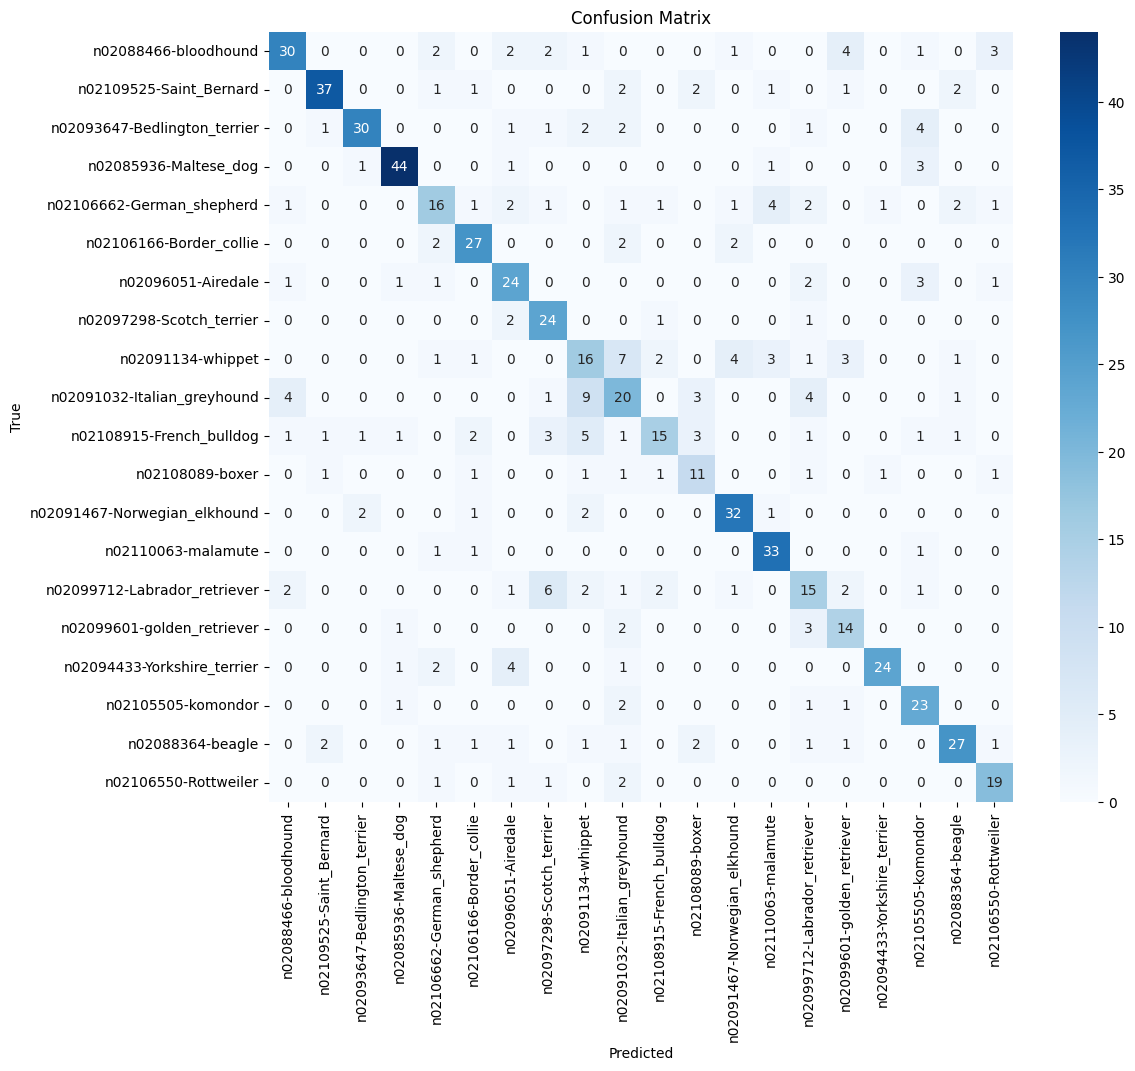

In [10]:
# Load Best Model
from tensorflow.keras.models import load_model
best_model = load_model('model.h5')

# Predict on Test Set
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Overall Metrics
accuracy = accuracy_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f"Overall Accuracy: {accuracy:.2%}")
print(f"Overall F1 Score (Weighted): {f1:.4f}")
print("-" * 30)

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=categories))

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=categories, yticklabels=categories, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 8. Prediction Utility

In [11]:
def predict_image(image_path):
    """Predicts the breed of a dog from an image file."""
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return
        
    # Load and Preprocess
    img = cv2.imread(image_path)
    img = cv2.resize(img, config['IMAGE_SIZE'])
    img = img.astype('float32')
    
    # Standardization (using training set statistics)
    img = (img - mean) / (std + 1e-7)
    img = np.expand_dims(img, axis=0)
    
    # Inference
    prediction = model.predict(img)
    predicted_class_idx = np.argmax(prediction)
    confidence = np.max(prediction)
    
    predicted_breed = categories[predicted_class_idx]
    
    # Output Results
    print(f"Predicted Breed: {predicted_breed}")
    print(f"Confidence: {confidence:.2%}")
    
    # Display Image
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title(f"{predicted_breed} ({confidence:.2%})")
    plt.axis('off')
    plt.show()

2025-12-05 22:06:20.922614: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[1,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,28,28]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-12-05 22:06:21.021569: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[1,256,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,256,14,14]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_targe

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Breed: n02106550-Rottweiler
Confidence: 99.98%


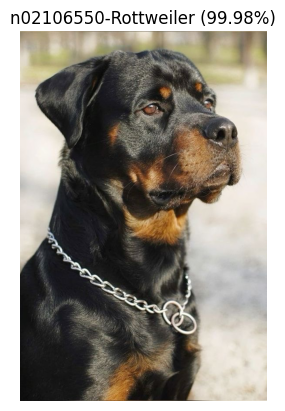

In [ ]:
predict_image('/Team_39/image.JPG')